## 1. Import libraries

In [5]:
! pip install split-folders

In [41]:
import os
import cv2
import numpy as np
import matplotlib.cm as cm
import tensorflow as tf
import random
import PIL
from PIL import Image, ImageOps
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import splitfolders
%matplotlib inline

## 2. Data preparation

In [69]:
splitfolders.ratio('rooms_dataset_simple', output="rooms_dataset", seed=42, ratio=(0.8, 0.2)) 

In [70]:
os.listdir(f'rooms_dataset/train')  # Directory where training data folders are

['baño',
 'exterior',
 'placa_calle',
 'zonas_comunes',
 'llaves',
 'plano',
 'zona_comercial',
 'cocina',
 'garaje',
 'habitación']

In [71]:
num_classes = len(os.listdir(f'rooms_dataset/train'))
dataset_dir ="rooms_dataset"
batch_size = 32  # Training batch size
print(num_classes)

10


In [72]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# preprocessing image and divide validaiton set
train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                   brightness_range=[0.5,1.5], 
                                   zoom_range=[0.3,1], 
                                   rotation_range=5)

train_generator = train_datagen.flow_from_directory(dataset_dir+'/train',
                                                 target_size=(224,224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='training')

validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_directory(dataset_dir+'/val',
                                                            target_size=(224,224),
                                                            batch_size=batch_size,
                                                            class_mode='categorical')



Found 825 images belonging to 10 classes.
Found 211 images belonging to 10 classes.


In [73]:
classes = train_generator.class_indices
print(classes)

{'baño': 0, 'cocina': 1, 'exterior': 2, 'garaje': 3, 'habitación': 4, 'llaves': 5, 'placa_calle': 6, 'plano': 7, 'zona_comercial': 8, 'zonas_comunes': 9}


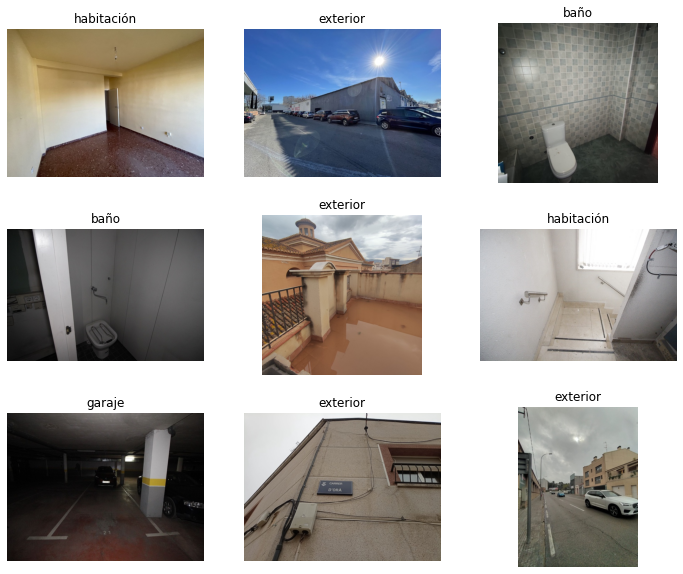

In [74]:
class_names = list(classes.keys())

fig, axes = plt.subplots(3,3, figsize=(12, 10))
indices = np.random.randint(0, 624, size=9)
for i, ax in enumerate(axes.flatten()):
    indx = indices[i]
    im = Image.open(train_generator.filepaths[indx])
    ax.imshow(im)
    ax.set_title(class_names[train_generator.classes[indx]])
    ax.axis('off')

## 3. Download network

In [22]:
#Get the places356 weights
weights_file = 'vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = tf.keras.utils.get_file(weights_file, 'https://github.com/GKalliatakis/Keras-VGG16-places365/releases/download/v1.0/vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5')

58909656/58909656 [==============================] - 88s 1us/step


In [125]:
base_model = vgg16.VGG16(weights = weights_path , include_top=False, input_shape = (224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [126]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers:
    layer.trainable = False

#if fine_tune es decir cuantas capas quieres reentrenar
# for layer in base_model.layers[:-fine_tune]:
# layer.traineble = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [128]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# save the output of the last layer to be the input of the next layer
last_layer = base_model.output

# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten(name="flatten")(last_layer)

# add two FC layers, 50 and 20 units and relu activation 
x = Dense(50, activation='relu')(x)
x = Dense(30, activation='relu')(x)

x = Dense(num_classes, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)

# print the new_model summary
new_model.summary()


Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [129]:
new_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [130]:
import math
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K

early_stop = EarlyStopping(monitor='val_loss',
                           patience=20,
                           restore_best_weights=True,
                           mode='min')

checkpoint = ModelCheckpoint('logs/ep{epoch:03}-val_loss{val_accuracy:.3f}.h5', monitor='val_loss',save_best_only=True, verbose=1)

In [131]:
history = new_model.fit(train_generator, batch_size=batch_size, validation_data=validation_generator, epochs=100, verbose=2, callbacks=[checkpoint, early_stop])

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.18478, saving model to logs/ep001-val_loss0.739.h5
26/26 - 172s - loss: 3.3908 - accuracy: 0.5309 - val_loss: 1.1848 - val_accuracy: 0.7393 - 172s/epoch - 7s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.18478 to 0.62743, saving model to logs/ep002-val_loss0.853.h5
26/26 - 175s - loss: 1.1536 - accuracy: 0.7418 - val_loss: 0.6274 - val_accuracy: 0.8531 - 175s/epoch - 7s/step
Epoch 3/100

Epoch 3: val_loss did not improve from 0.62743
26/26 - 198s - loss: 0.7944 - accuracy: 0.7952 - val_loss: 0.7675 - val_accuracy: 0.8104 - 198s/epoch - 8s/step
Epoch 4/100

Epoch 4: val_loss did not improve from 0.62743
26/26 - 194s - loss: 0.8421 - accuracy: 0.7830 - val_loss: 0.8346 - val_accuracy: 0.8199 - 194s/epoch - 7s/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.62743
26/26 - 193s - loss: 0.5691 - accuracy: 0.8509 - val_loss: 0.8363 - val_accuracy: 0.8294 - 193s/epoch - 7s/step
Epoch 6/100

Epoch 6: val_loss did not improve

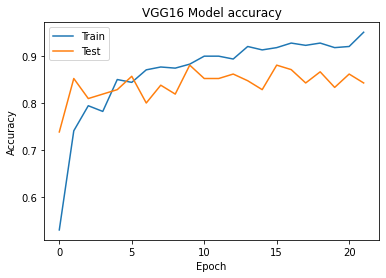

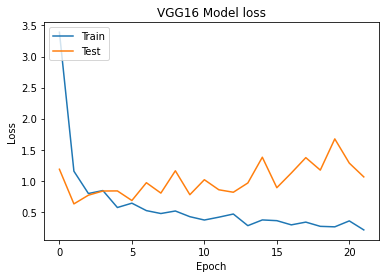

In [132]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG16 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [133]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = new_model.predict_generator(validation_generator, 211 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=class_names))

#Evaluating using Keras model_evaluate:
x, y = zip(*(validation_generator[i] for i in range(len(validation_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)
loss, acc = new_model.evaluate(x_test, y_test, batch_size=32)

print("Accuracy: " ,acc)
print("Loss: ", loss)

/tmp/ipykernel_6908/4136146843.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = new_model.predict_generator(validation_generator, 211 // batch_size+1)


Confusion Matrix
[[ 3  4  8  0 11  0  0  0  2  1]
 [ 3  0  3  0  7  0  0  0  2  1]
 [10  4 20  0 14  1  0  0  6  3]
 [ 1  0  0  0  1  0  0  0  0  0]
 [12  3 19  1 23  1  0  0  3  7]
 [ 0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0]
 [ 3  0  4  0  4  0  0  0  1  0]
 [ 3  2  7  0  9  0  0  0  1  0]]
Classification Report
                precision    recall  f1-score   support

          baño       0.09      0.10      0.09        29
        cocina       0.00      0.00      0.00        16
      exterior       0.33      0.34      0.34        58
        garaje       0.00      0.00      0.00         2
    habitación       0.32      0.33      0.33        69
        llaves       0.00      0.00      0.00         1
   placa_calle       0.00      0.00      0.00         1
         plano       0.00      0.00      0.00         1
zona_comercial       0.07      0.08      0.07        12
 zonas_comunes       0.00      0.00      0.00        22

      accura

/home/irene/tfm_env/tfm_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/irene/tfm_env/tfm_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/irene/tfm_env/tfm_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 34s 5s/step - loss: 0.6274 - accuracy: 0.8531
Accuracy:  0.8530805706977844
Loss:  0.6274345517158508
